In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from data_utils import load_metadata, sample_sounds_by_category, load_wave_data, load_all_sounds
from plot_utils import visualize_category_sounds,create_histogram_subplot
from feature_utils import compute_features_for_wave_list, compute_combined_features_for_wave_list, save_features_to_npz, save_multiple_features_to_npz
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

In [2]:
# 1) Specify paths
csv_file_path = "datasets/ESC-50-master/meta/esc50.csv"
audio_files_path = "datasets/ESC-50-master/audio/"

# 1.1) check if the paths exist
assert os.path.exists(csv_file_path), "CSV file not found!"
assert os.path.exists(audio_files_path), "Audio directory not found!"


In [3]:
# 2) Load metadata
df = load_metadata(csv_file_path)

print(df)
print("Missing values:\n", df.isnull().sum()) # Check for missing values
print(df.describe()) # Show summary statistics

               filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1995   5-263831-B-6.wav     5       6             hen  False    263831    B
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[2000 rows x 7 columns]
Missing values:
 filename    0
fold        0
target      0
cate

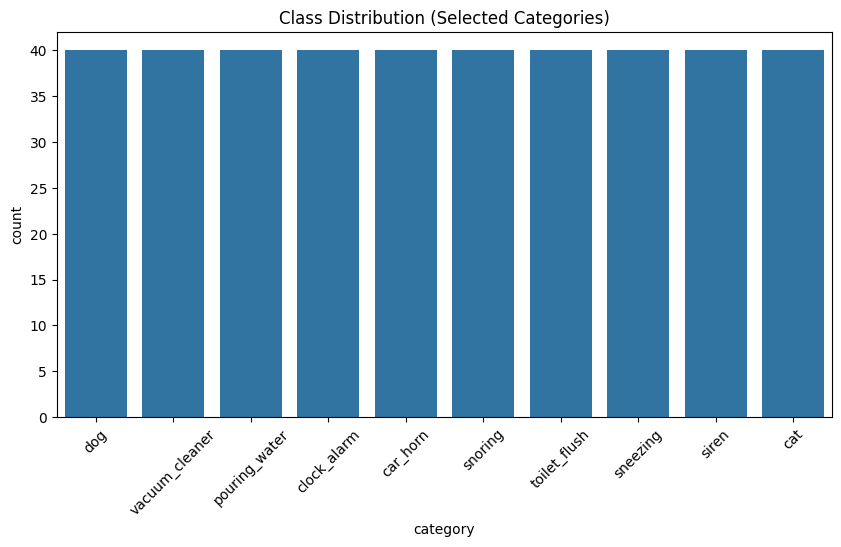

In [5]:
# 3) Define categories
categories = {
        'Animals': ['dog', 'cat'],
        'Natural soundscapes & water sounds': ['toilet_flush', 'pouring_water'],
        'Human sounds': ['snoring', 'sneezing'],
        'Interior/domestic sounds': ['clock_alarm', 'vacuum_cleaner'],
        'Exterior/urban noises': ['siren', 'car_horn']
    }
# Filter the dataframe to only include selected categories
selected_classes = sum(categories.values(), [])  # Flatten the dictionary into a list of class names
df_filtered = df[df['category'].isin(selected_classes)]  # Keep only selected categories

# Plot class distribution of selected categories
plt.figure(figsize=(10, 5))
sns.countplot(x=df_filtered['category'])
plt.xticks(rotation=45)
plt.title("Class Distribution (Selected Categories)")
plt.show()


In [6]:
# Create a mapping dictionary from category to its target number
category_to_target = dict(zip(df_filtered['category'], df_filtered['target']))

# Print the dictionary
print("Category to Target Mapping:\n", category_to_target)

Category to Target Mapping:
 {'dog': 0, 'vacuum_cleaner': 36, 'pouring_water': 17, 'clock_alarm': 37, 'car_horn': 43, 'snoring': 28, 'toilet_flush': 18, 'sneezing': 21, 'siren': 42, 'cat': 5}


In [7]:
# 4) Sample sounds
sampled_sounds = sample_sounds_by_category(df, categories)

# Track missing and represented classes
missing_classes = {}
represented_classes = {}

for category, expected_classes in categories.items():
    # Extract actual classes from sampled sounds
    sampled_classes = set(df[df['filename'].isin(sampled_sounds[category])]['category'])
    
    # Check which classes are missing
    missing = set(expected_classes) - sampled_classes
    represented_classes[category] = sampled_classes

    if missing:
        missing_classes[category] = missing

    print(f"Category: {category}, Sampled Classes: {sampled_classes}")

# Summary
print("\n✅ Represented Classes:")
for category, classes in represented_classes.items():
    print(f"- {category}: {classes}")

if missing_classes:
    print("\n❌ Missing Classes:")
    for category, classes in missing_classes.items():
        print(f"- {category}: {classes}")
else:
    print("\n🎉 All expected classes are present!")


Category: Animals, Sampled Classes: {'cat', 'dog'}
Category: Natural soundscapes & water sounds, Sampled Classes: {'pouring_water', 'toilet_flush'}
Category: Human sounds, Sampled Classes: {'sneezing', 'snoring'}
Category: Interior/domestic sounds, Sampled Classes: {'vacuum_cleaner', 'clock_alarm'}
Category: Exterior/urban noises, Sampled Classes: {'siren', 'car_horn'}

✅ Represented Classes:
- Animals: {'cat', 'dog'}
- Natural soundscapes & water sounds: {'pouring_water', 'toilet_flush'}
- Human sounds: {'sneezing', 'snoring'}
- Interior/domestic sounds: {'vacuum_cleaner', 'clock_alarm'}
- Exterior/urban noises: {'siren', 'car_horn'}

🎉 All expected classes are present!


In [8]:
# 5) Load wave data
wave_list_data_sampled = load_wave_data(sampled_sounds, audio_files_path) #load_sample
wave_list_data = load_all_sounds(df, categories, audio_files_path) #load all sounds

print("Total samples loaded:", len(wave_list_data))
print("Example sample rate:", wave_list_data[0][2])
print("Example waveform shape:", wave_list_data[0][3].shape)

Total samples loaded: 400
Example sample rate: 44100
Example waveform shape: (220500,)


Analyzing Animals category...


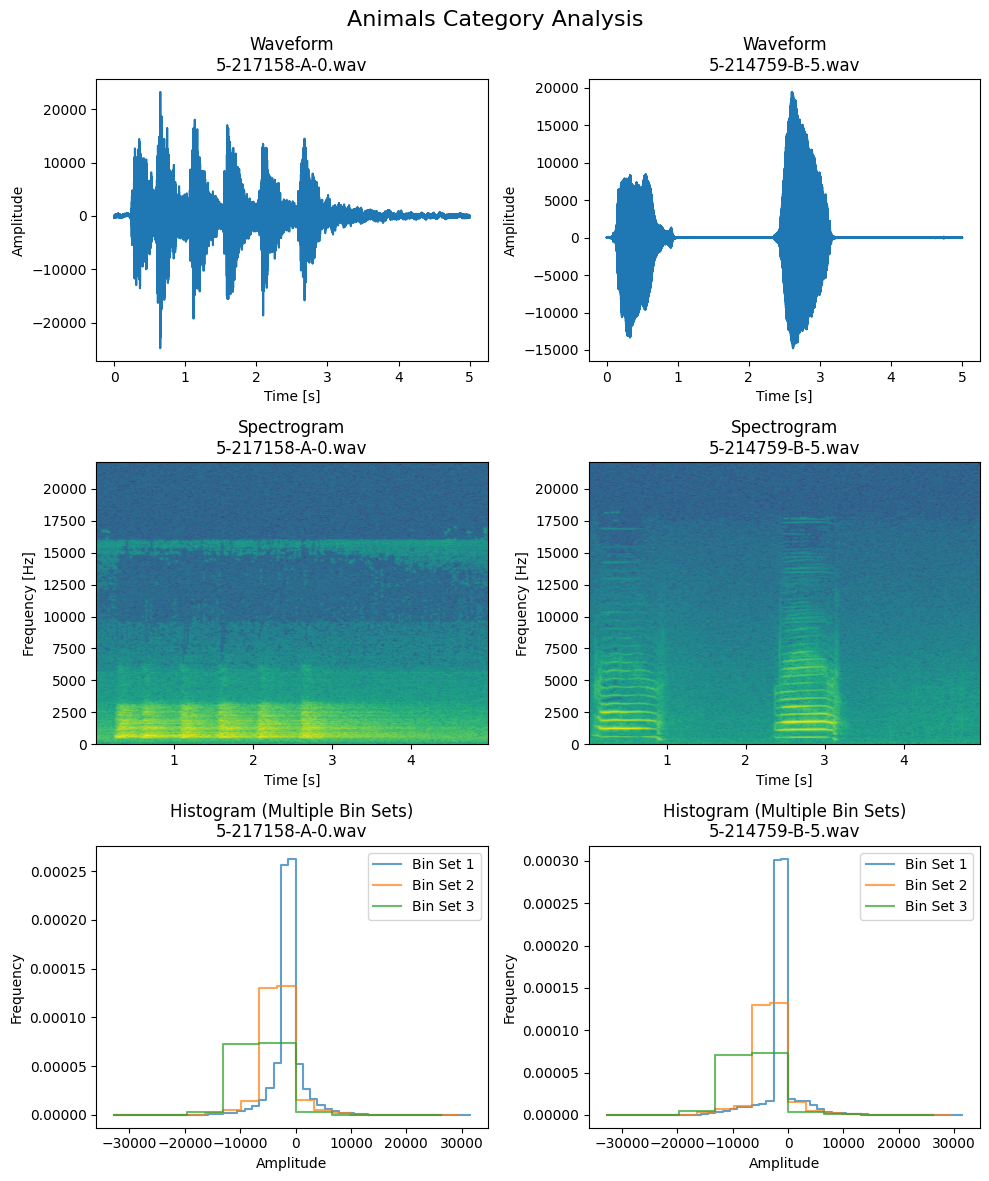

Analyzing Natural soundscapes & water sounds category...


/Users/minaghaderi/Documents/AML/AML-Soheil-Mina-Amir/plot_utils.py:50: RuntimeWarning: divide by zero encountered in log10
  im = ax.pcolormesh(t, f, 20 * np.log10(Sxx), shading='gouraud')


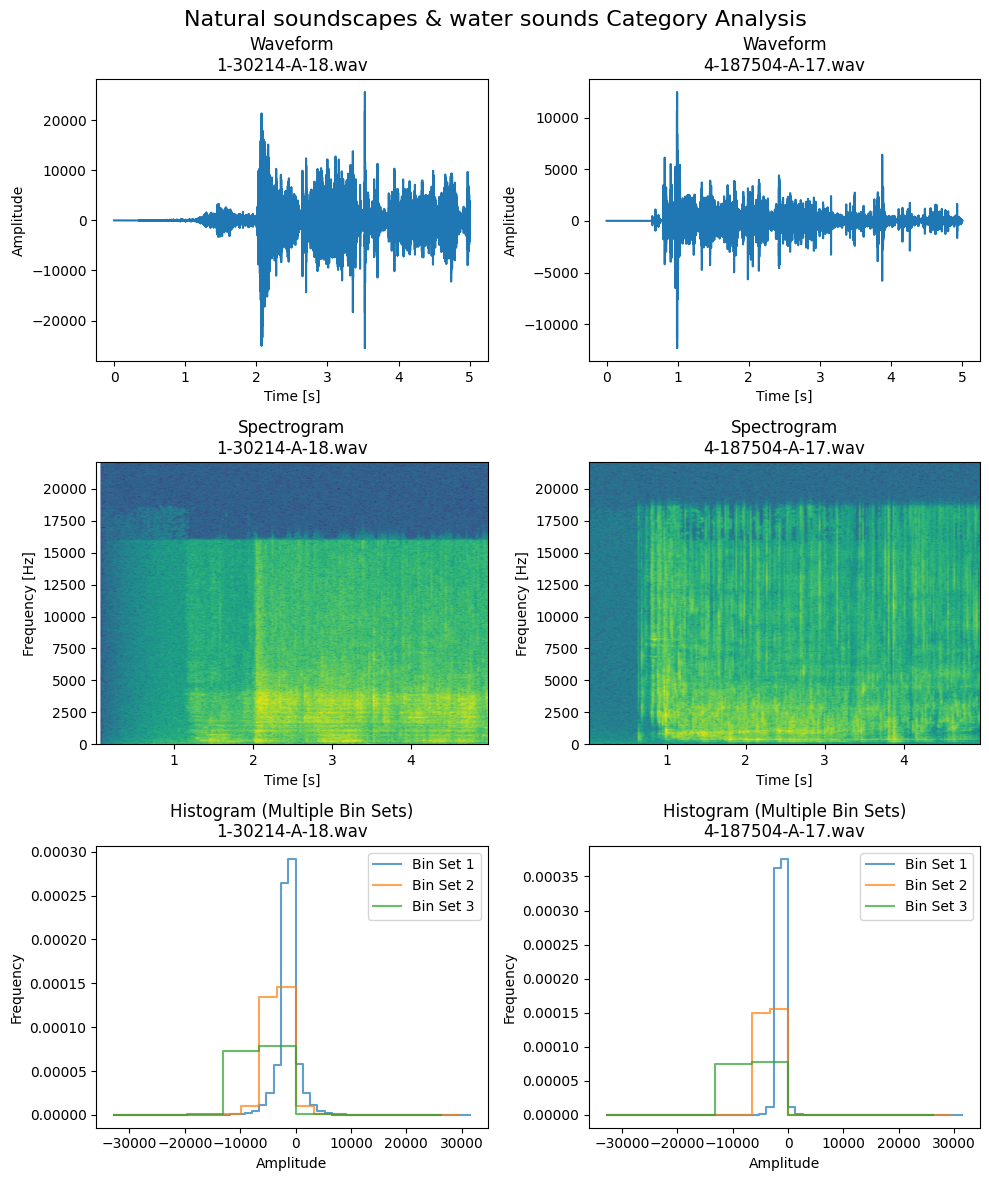

Analyzing Human sounds category...


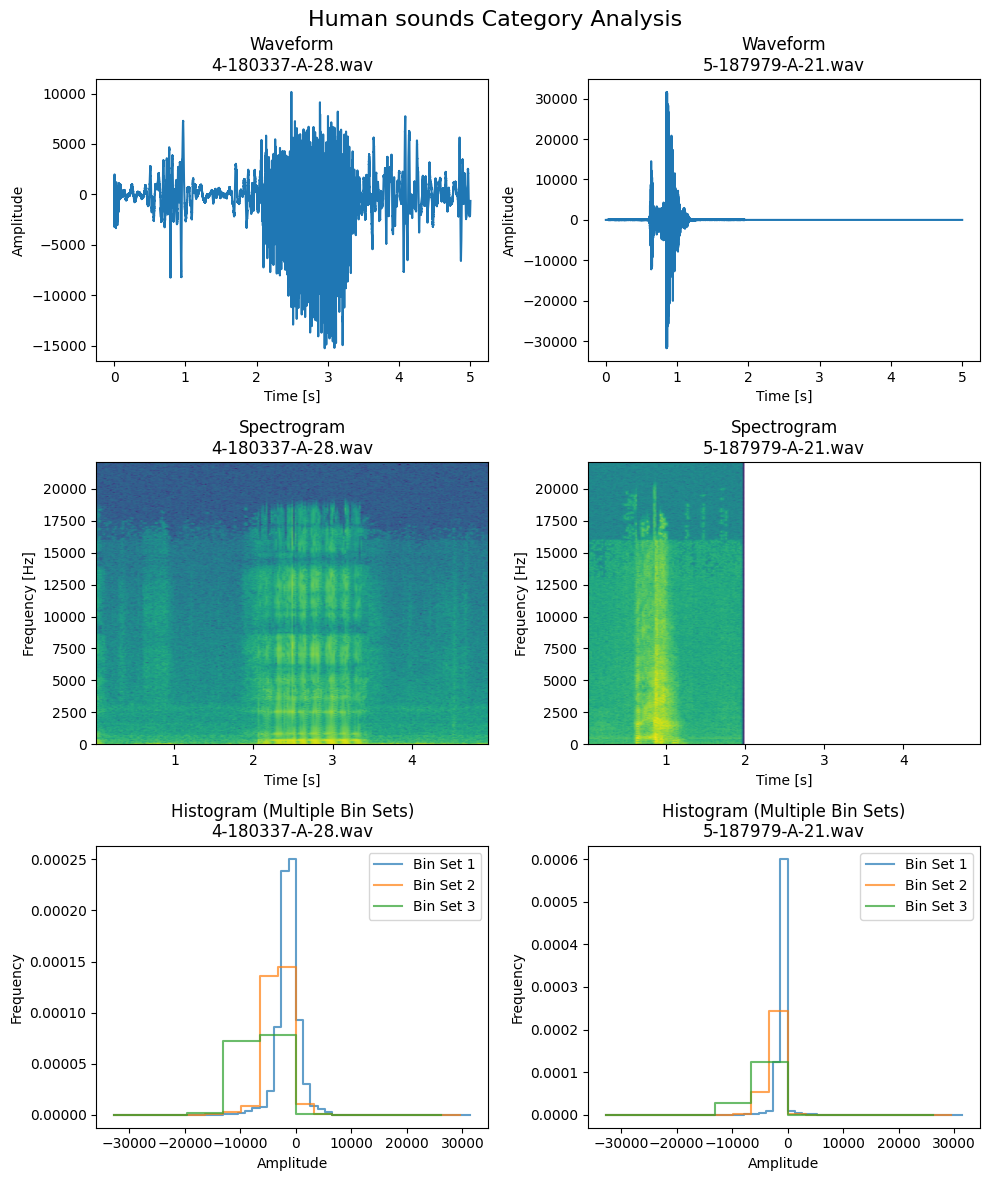

Analyzing Interior/domestic sounds category...


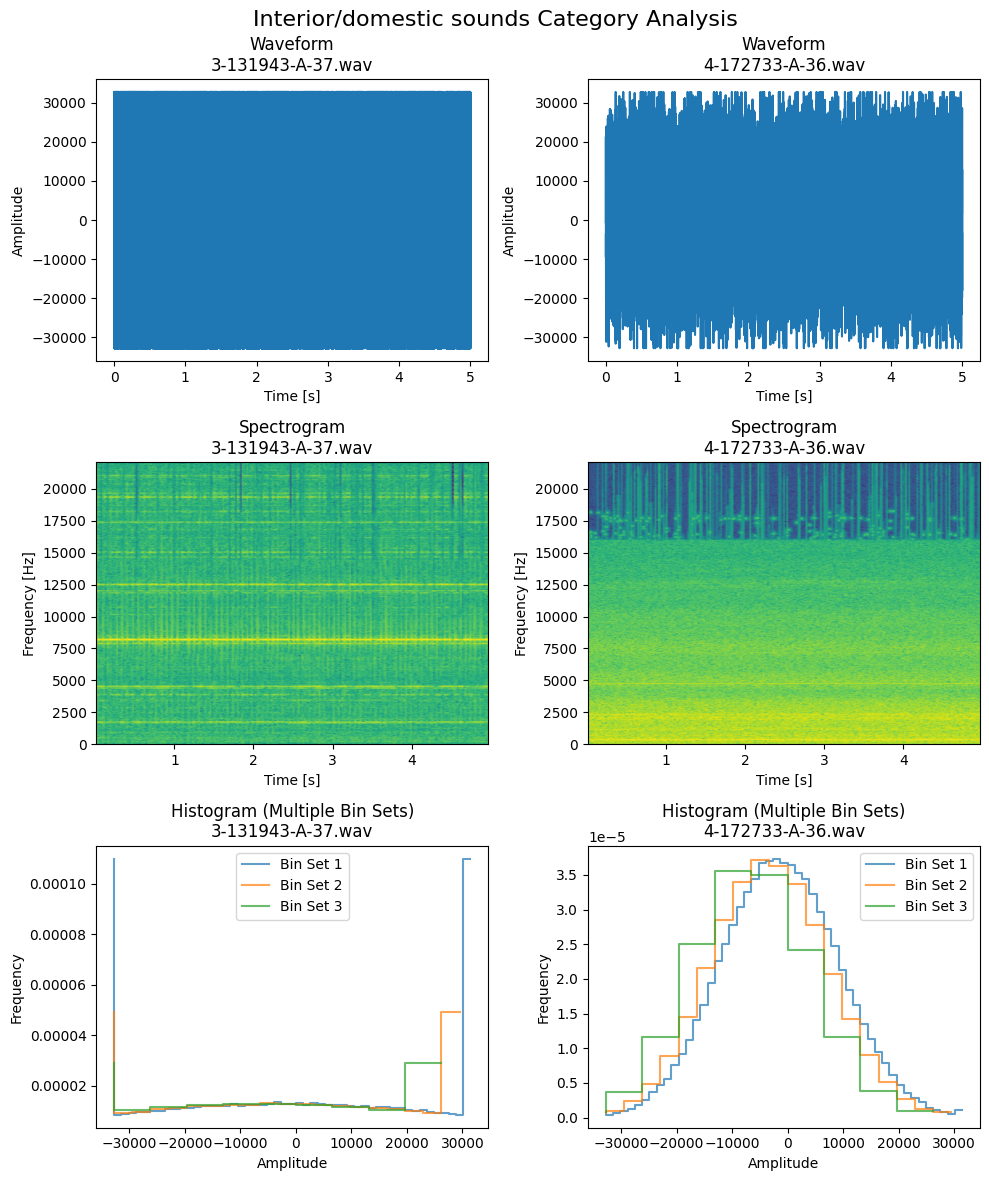

Analyzing Exterior/urban noises category...


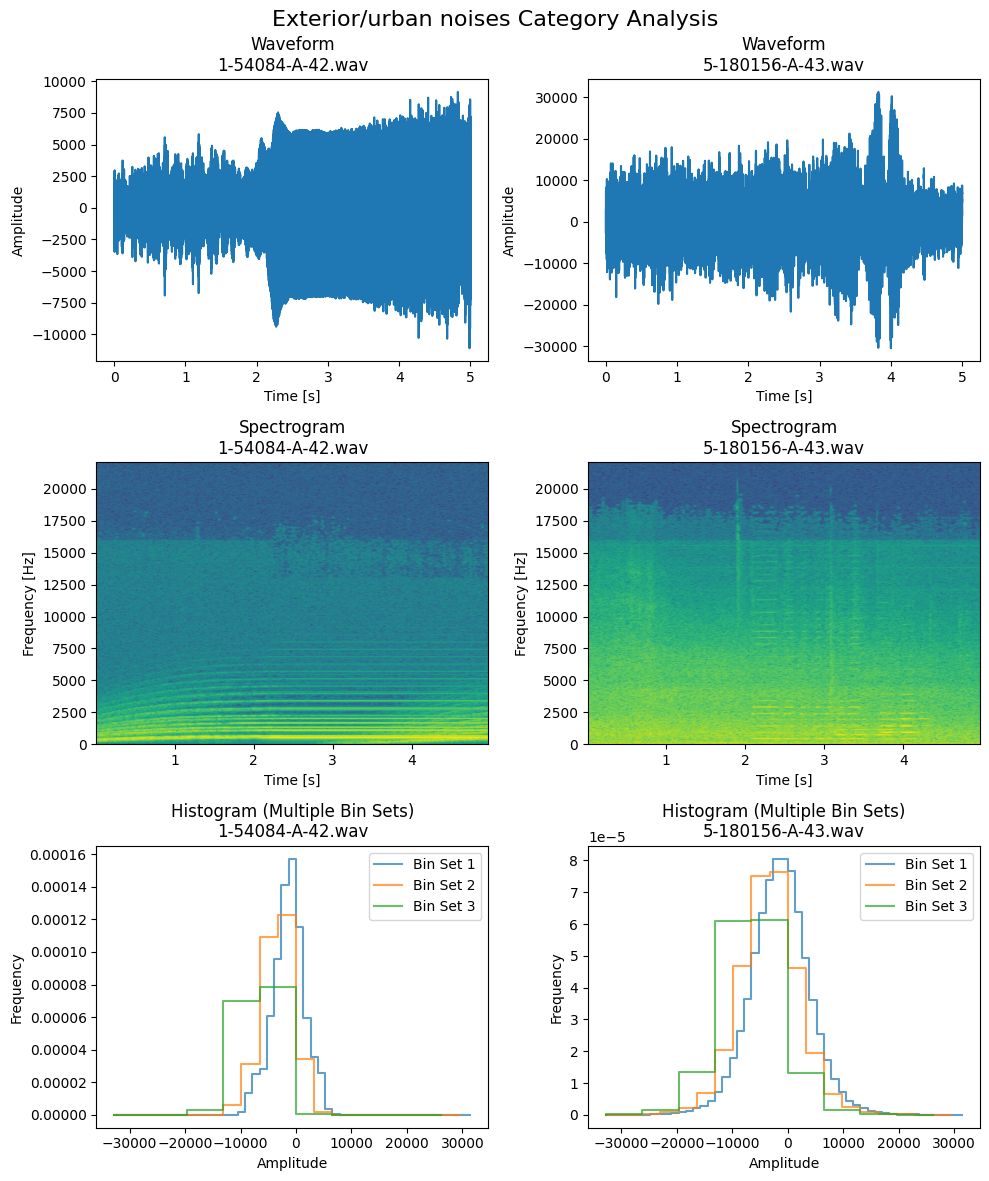

{'Animals': [{'bins_set_1': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 1.73004783e-08, 3.46009567e-09,
          6.92019134e-09, 3.46009567e-09, 2.42206697e-08, 7.61221047e-08,
          1.41863922e-07, 2.90648036e-07, 5.70915785e-07, 1.00688784e-06,
          1.65738583e-06, 2.45320783e-06, 4.25937777e-06, 6.13128952e-06,
          9.47720204e-06, 1.55358296e-05, 2.73312957e-05, 5.36868444e-05,
          2.55773732e-04, 2.62818487e-04, 5.26038344e-05, 2.69299246e-05,
          1.58749189e-05, 1.00308173e-05, 6.48421928e-06, 3.84070619e-06,
          2.43936745e-06, 1.61240458e-06, 8.09662386e-07, 5.01713872e-07,
          2.62967271e-07, 1.83385070e-07, 4.15211480e-08, 1.73004783e-08,
          1.38403827e-08, 1.38403827e-08, 2.42206697e-08, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00]),
   'bins_set_2': array([0.00000000e+00, 0.0

In [9]:
# 6) Visualize
visualize_category_sounds(wave_list_data_sampled)

In [10]:
# 7) Extract all features
keys_list, combined_features = compute_combined_features_for_wave_list(wave_list_data)

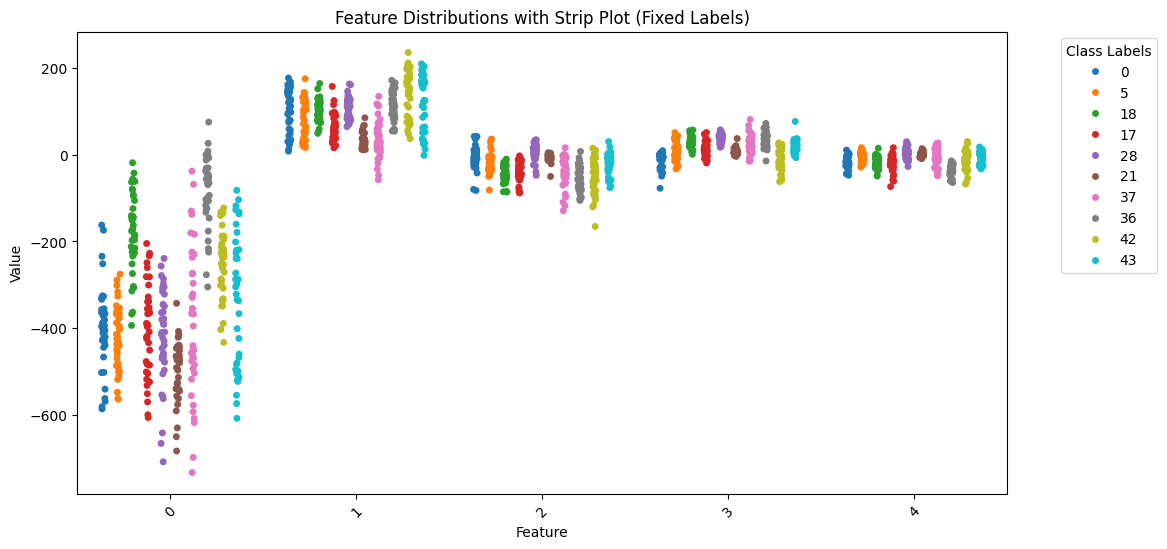

In [11]:
### Compare feature distributions for different classes

# Convert combined_features to DataFrame
df_features = pd.DataFrame(combined_features)
df_features["label"] = keys_list  # Add class labels

# Ensure labels are categorical, not just numbers
df_features["label"] = df_features["label"].astype(str)  # Convert to string labels

# Select first 5 features for visualization (modify if needed)
selected_features = df_features.iloc[:, :5]  
selected_features["label"] = df_features["label"]  # Re-add labels

# Convert to long format for plotting
df_melted = selected_features.melt(id_vars="label", var_name="Feature", value_name="Value")

# --- Strip Plot Fix ---
plt.figure(figsize=(12, 6))
sns.stripplot(x="Feature", y="Value", hue="label", data=df_melted, dodge=True, jitter=True)
plt.title("Feature Distributions with Strip Plot (Fixed Labels)")
plt.xticks(rotation=45)
plt.legend(title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')  # Fix legend
plt.show()



In [12]:
# 8) Save all features
save_features_to_npz(keys_list, combined_features, out_file="features/extracted_features_test.npz")

# Check file integrity after saving
loaded_data = np.load("features/extracted_features_test.npz")
print("Loaded feature shape:", loaded_data['features'].shape)
print("Keys shape:", loaded_data['keys'].shape)

Features saved to features/extracted_features_test.npz
Loaded feature shape: (400, 126)
Keys shape: (400,)


In [13]:
# 7) Extract selected features
keys_list, mfcc_list, hist_list, spectral_list = compute_features_for_wave_list(wave_list_data)

# 8) Save selected features
save_multiple_features_to_npz(keys_list, mfcc_list, hist_list, spectral_list, out_file="features/extracted_features_multiple_test.npz")

loaded_data = np.load("features/extracted_features_multiple_test.npz")
print("Stored arrays:", loaded_data.files)

print("Keys shape:", loaded_data['keys'].shape)
print("MFCC shape:", loaded_data['mfcc'].shape)
print("Histogram shape:", loaded_data['hist'].shape)
print("Spectral shape:", loaded_data['spectral'].shape)

#print("First MFCC feature vector:", loaded_data['mfcc'][0])
#print("First histogram feature vector:", loaded_data['hist'][0])
#print("First spectral feature vector:", loaded_data['spectral'][0])


Multiple features saved to features/extracted_features_multiple_test.npz
Stored arrays: ['keys', 'mfcc', 'hist', 'spectral']
Keys shape: (400,)
MFCC shape: (400, 26)
Histogram shape: (400, 80)
Spectral shape: (400, 20)


In [14]:
# Extract features and labels
keys_list = loaded_data['keys']
mfcc_features = loaded_data['mfcc']
hist_features = loaded_data['hist']
spectral_features = loaded_data['spectral']

combined_features = np.hstack([mfcc_features, hist_features, spectral_features])

In [15]:
# Train-Test Splitting
X = combined_features
y = np.array(keys_list)  # Ensure y is a NumPy array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y) # Split into training and testing sets

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Debugging: Check which classes exist in keys_list before splitting
unique_classes = set(keys_list)
print("Unique classes in dataset before splitting:", unique_classes)

# Count occurrences of each class in train and test sets
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

# Print class counts
print("Training Class Counts:\n", train_counts)
print("\nTest Class Counts:\n", test_counts)

Training set size: (320, 126)
Test set size: (80, 126)
Unique classes in dataset before splitting: {0, 36, 5, 37, 42, 43, 17, 18, 21, 28}
Training Class Counts:
 0     32
5     32
17    32
18    32
21    32
28    32
36    32
37    32
42    32
43    32
Name: count, dtype: int64

Test Class Counts:
 0     8
5     8
17    8
18    8
21    8
28    8
36    8
37    8
42    8
43    8
Name: count, dtype: int64


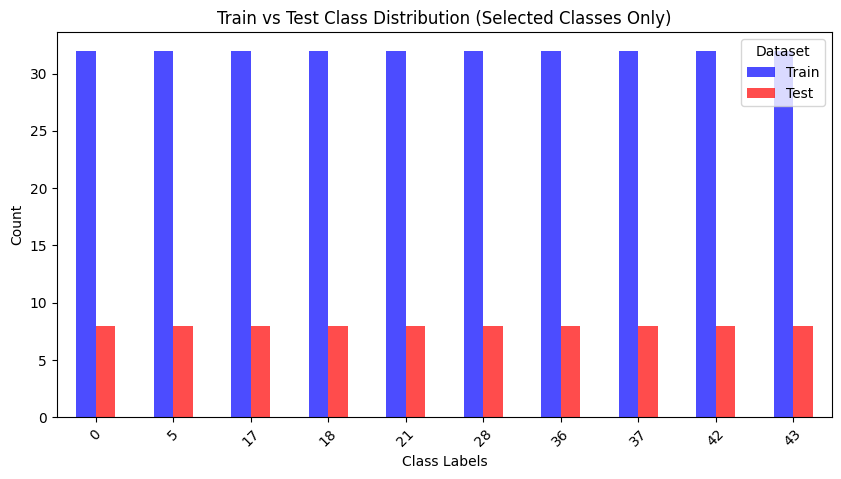

In [16]:
# Convert lists to Pandas Series for counting
train_counts = pd.Series(y_train).value_counts()
test_counts = pd.Series(y_test).value_counts()

# Merge train and test counts into a single DataFrame
df_counts = pd.DataFrame({'Train': train_counts, 'Test': test_counts}).fillna(0)

# Plot bar chart for class distributions
df_counts.plot(kind="bar", figsize=(10, 5), color=["blue", "red"], alpha=0.7)
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Train vs Test Class Distribution (Selected Classes Only)")
plt.xticks(rotation=45)
plt.legend(title="Dataset")
plt.show()


In [17]:
# Define Stratified K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Reasonable range of C values
    'gamma': [0.01, 0.1, 1, 'scale', 10, 100],  # Includes 'scale'
    'kernel': ['rbf']  # Using only RBF kernel
}

# Perform GridSearch with Stratified K-Fold
grid_search = GridSearchCV(SVC(), param_grid, cv=kfold, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Print best hyperparameters
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           5       0.43      0.38      0.40         8
          17       0.50      0.50      0.50         8
          18       0.78      0.88      0.82         8
          21       0.43      0.75      0.55         8
          28       0.56      0.62      0.59         8
          36       0.88      0.88      0.88         8
          37       1.00      0.50      0.67         8
          42       0.75      0.75      0.75         8
          43       0.25      0.12      0.17         8

    accuracy                           0.60        80
   macro avg       0.61      0.60      0.59        80
weighted avg       0.61      0.60      0.59        80



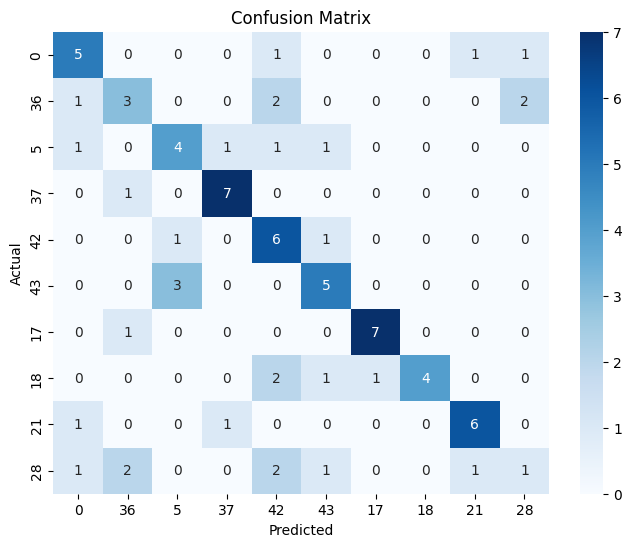

In [18]:
# Initialize the SVM classifier
svm = SVC(kernel='rbf', C=100, gamma='scale', random_state=42)

# Train the SVM classifier
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_train), yticklabels=set(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packa

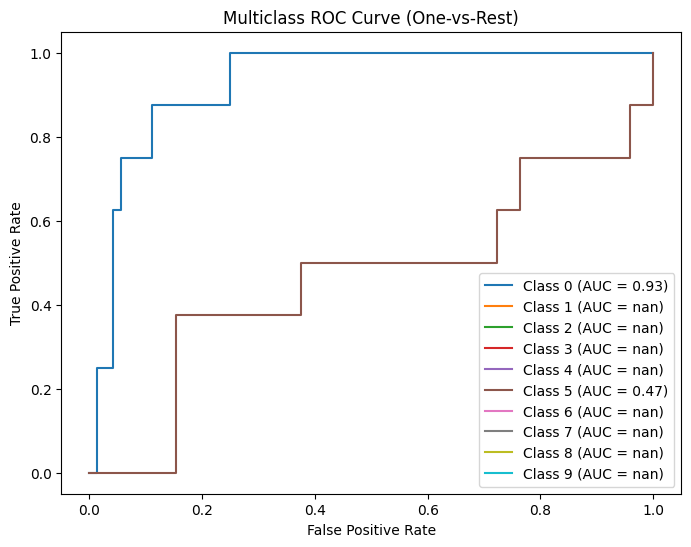

In [19]:
# Get decision function scores
y_scores = svm.decision_function(X_test)

num_classes = y_scores.shape[1]  # Number of classes

plt.figure(figsize=(8, 6))

for class_idx in range(num_classes):
    # Convert multi-class labels into binary (One vs. Rest)
    y_test_binary = (y_test == class_idx).astype(int)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test_binary, y_scores[:, class_idx])
    roc_auc = auc(fpr, tpr)

    # Plot each class's ROC curve
    plt.plot(fpr, tpr, label=f"Class {class_idx} (AUC = {roc_auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.show()


In [20]:
# Reduce features to 10 dimensions using PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Reduced feature shape:", X_train_pca.shape)

Explained variance ratio: [7.91544394e-01 1.54477311e-01 4.37811924e-02 5.65493035e-03
 3.83027923e-03 2.63051047e-04 1.34657216e-04 7.74361879e-05
 6.26268028e-05 3.98910991e-05]
Reduced feature shape: (320, 10)


In [21]:
vm = SVC(kernel='rbf', C=100, gamma='scale', random_state=42)
svm.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = svm.predict(X_test_pca)

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.88      0.67         8
           5       0.50      0.50      0.50         8
          17       0.56      0.62      0.59         8
          18       0.70      0.88      0.78         8
          21       0.54      0.88      0.67         8
          28       0.71      0.62      0.67         8
          36       0.86      0.75      0.80         8
          37       1.00      0.62      0.77         8
          42       0.83      0.62      0.71         8
          43       0.00      0.00      0.00         8

    accuracy                           0.64        80
   macro avg       0.62      0.64      0.61        80
weighted avg       0.62      0.64      0.61        80



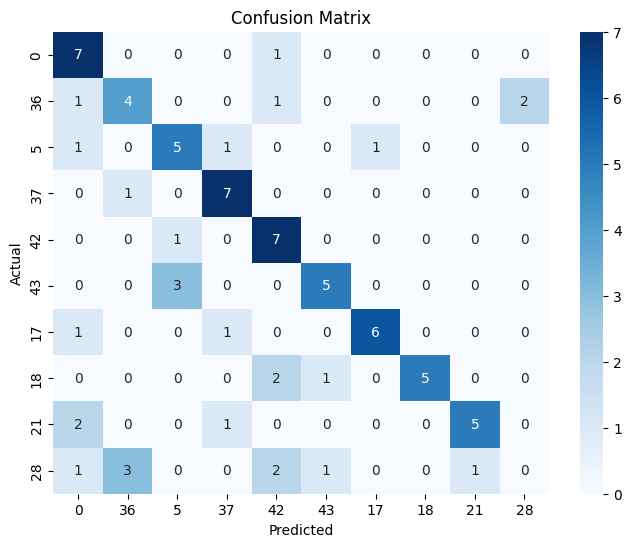

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_train), yticklabels=set(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()